In [1]:
import os
import numpy as np
from scipy.io import wavfile
from aubio import onset
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

import dsp
from read_labels import read_labels

%matplotlib inline

In [2]:
rootdir = '/home/tracek/Data/Birdman/'
filename = os.path.join(rootdir, 'raw/16khz/STHELENA-02_20140605_200000_1.wav')
outdir = os.path.join(rootdir, 'raw/samples/')
sheets = read_labels('/home/tracek/Data/Birdman/labels/sthelena_labels.xls')
filename_noext = os.path.splitext(os.path.basename(filename))[0]
sheet = sheets[filename_noext]

# in seconds [s]
signal_start_s = 0
signal_end_s = 95
min_duration_s = 0.200
max_duration_s = 0.750

win = 256 # samples
hop = win // 2

onset_detector = 'hfc' # other options: complex, phase, specdiff, kl, mkl, specflux, energy
onset_threshold = 0.01
onset_silence_threshold = -70

highpass_cut = 500 # Hz

write_waves = False

In [3]:
sr, signal = wavfile.read(filename)
scaling_factor = 2**15 # signal.max()
signal_norm = signal.astype('float32') / scaling_factor

In [4]:
condition = (sheet['Time Start'] > signal_start_s) & (sheet['Time End'] < signal_end_s)
sheet_selected = sheet[condition]
signal_selected = signal_norm[int(signal_start_s * sr): int(signal_end_s * sr)]
signal_filtered = dsp.highpass_filter(signal_selected, sr=sr, highcut=highpass_cut)
signal_windowed = np.array_split(signal_filtered, np.arange(hop, len(signal_filtered), hop))

In [5]:
def onset_in_call(onset, calls_list, buffer=0):
    for index, call in calls_list.iterrows():
        if call['Time Start'] - buffer <= onset <= call['Time End'] + buffer:
            return call['Species']
    else:
        return None
    
def plot_specgram_extra(signal, sr, nfft, hop, signal_start_s, signal_end_s, labels=None, onsets=None):
    x_spacing = np.linspace(signal_start_s, signal_end_s, len(signal))
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    if labels is not None:
        for index, row in labels.iterrows():
            if row['Species'] == 'Storm Petrel':
                ax.axvspan(xmin=row['Time Start'], xmax=row['Time End'], color='red', alpha=0.1)
            else:
                ax.axvspan(xmin=row['Time Start'], xmax=row['Time End'], color='green', alpha=0.2)
    if onsets:
        for onset in onsets:
            ax.axvline(x=onset, color='blue', alpha=0.3)
            if onset_in_call(onset, labels, buffer=0):
                plt.plot(onset, 6000, 'ro')
    spec = plt.specgram(signal_filtered, Fs=sr, NFFT=nfft, noverlap=hop, xextent=(signal_start_s, signal_end_s))

In [6]:
onsets = dsp.get_onsets(signal_filtered, sr, nfft=win, hop=hop, onset_detector_type=onset_detector, 
                        onset_threshold=onset_threshold, onset_silence_threshold=onset_silence_threshold,
                        min_duration_s=min_duration_s)

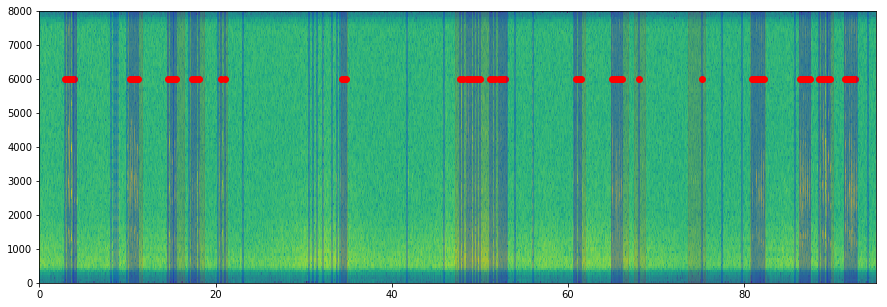

In [7]:
plot_specgram_extra(signal_selected, sr, win, hop, signal_start_s, signal_end_s, sheet_selected, onsets)

In [12]:
slices_fixed = dsp.get_slices(signal_filtered, sr, method='fixed', nfft=win, hop=hop, onset_detector_type=onset_detector, 
                        onset_threshold=onset_threshold, onset_silence_threshold=onset_silence_threshold,
                        min_duration_s=min_duration_s, max_duration_s=max_duration_s)
print('No slices fixed: ', len(slices_fixed))

slices_dyn = dsp.get_slices(signal_filtered, sr, method='dynamic', nfft=win, hop=hop, onset_detector_type=onset_detector, 
                        onset_threshold=onset_threshold, onset_silence_threshold=onset_silence_threshold,
                        min_duration_s=min_duration_s, max_duration_s=0.7)
print('No slices dynamic: ', len(slices_dyn))

No slices fixed:  101
No slices dynamic:  100


In [13]:
slices_fixed_len = [end - start for start, end in slices_fixed]
slices_dyn_len = [end - start for start, end in slices_dyn]

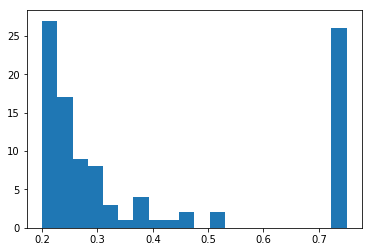

In [15]:
h = plt.hist(slices_fixed_len, bins=20)

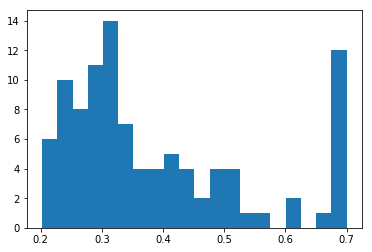

In [14]:
h = plt.hist(slices_dyn_len, bins=20)

In [11]:
# sample *= 32767
if write_waves:
    for start, end in chunks_s[1:]:
        basename = os.path.basename(filename)
        dirname = os.path.dirname(filename)
        call = onset_in_call(start, sheet_selected, buffer=min_duration_s/2)
        if call:
            chunk_name = '{}_{:07.3f}_{:07.3f}_{}.wav'.format(os.path.splitext(basename)[0], start, end, call)
        else:
            chunk_name = '{}_{:07.3f}_{:07.3f}.wav'.format(os.path.splitext(basename)[0], start, end)
        start_sample = int(start * sr)
        end_sample = int(end * sr)
        chunk_path_out = os.path.join(dirname, chunk_name)
        wavfile.write(chunk_path_out, sr, signal[start_sample: end_sample])